In [1]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Retrain or use existing models
use_cached_weights=False

# Control figure size
figsize=(14, 3.5)
figsize_narrow=(14, 2.5)

from util import util
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')


# Generate a problem instance
nitems, rel_req, seed = 20, 0.5, 42
prb = util.generate_problem(nitems=nitems, rel_req=rel_req, seed=seed)

# Generate basic dataset
data_tr = util.generate_costs(nsamples=350, nitems=nitems, seed=seed, noise_scale=0, noise_type='normal', noise_scale_type='absolute')
data_ts = util.generate_costs(nsamples=150, nitems=nitems, seed=seed, sampling_seed=seed+1, noise_scale=0, noise_type='normal', noise_scale_type='absolute')

2023-07-08 15:11:07.605699: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 15:11:07.825806: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-08 15:11:07.826883: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-08 15:11:08.827616: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Picking a Direction

**RAMBLE PICTURE HERE**

## Let's Second-Guess Ourselvers

**However, let's not discount the prediction-focused approach yet**

In fact, it's easy to see that:

$$
\mathbb{E}[\text{regret}(\hat{y}, y)] \xrightarrow[\mathbb{E}\lbrack L(\hat{y}, y) \rbrack \to 0]{} 0
$$

Intuitively:;

* The more accurate we can be, the lower the regret
* Eventually, perfect predictions will result in 0 regret

**But then... What if we make our model bigger?**

* We could get good predictions _and_ good regret
* ...And training would be _much_ faster

## Our Baseline

**Let's check again the results for our PFL linear regressor**

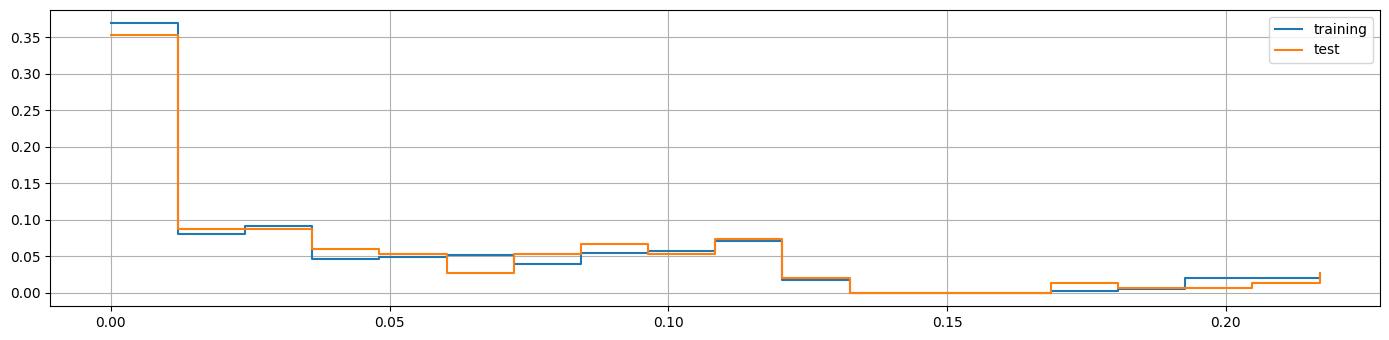

Mean: 0.052 (training), 0.052 (test)


In [2]:
pfl = util.build_nn_model(input_shape=1, output_shape=nitems, hidden=[], name='pfl_det', output_activation='linear')
history = util.train_nn_model(pfl, data_tr.index.values, data_tr.values, epochs=1000, loss='mse', validation_split=0, save_weights=True, load_weights=True)
r_tr = util.compute_regret(prb, pfl, data_tr.index.values, data_tr.values)
r_ts = util.compute_regret(prb, pfl, data_ts.index.values, data_ts.values)
util.plot_histogram(r_tr, figsize=figsize, label='training', data2=r_ts, label2='test', print_mean=True)

This will be our main baseline

## PFL Strikes Back

**Let's try to actually do it**

CPU times: user 9.32 s, sys: 319 ms, total: 9.64 s
Wall time: 7.31 s


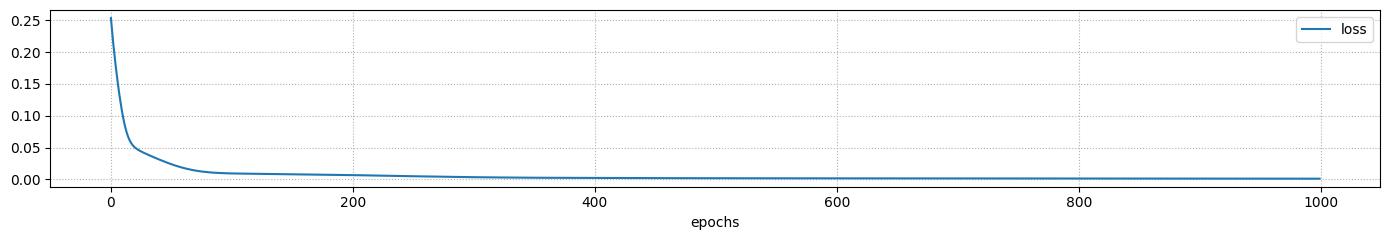

R2: 0.98, MAE: 0.025, RMSE: 0.04 (training)
R2: 0.98, MAE: 0.025, RMSE: 0.04 (test)


In [3]:
pfl_acc = util.build_nn_model(input_shape=1, output_shape=nitems, hidden=[8], name='pfl_det_acc', output_activation='linear')
%time history = util.train_nn_model(pfl_acc, data_tr.index.values, data_tr.values, epochs=1000, loss='mse', validation_split=0, save_weights=True, load_weights=use_cached_weights)
util.plot_training_history(history, figsize=figsize_narrow, print_final_scores=False)
util.print_ml_metrics(pfl_acc, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(pfl_acc, data_ts.index.values, data_ts.values, label='test')

More accurate, it is!

## PFL Strikes Back

**...And the improvement in terms of regret is remarkable**

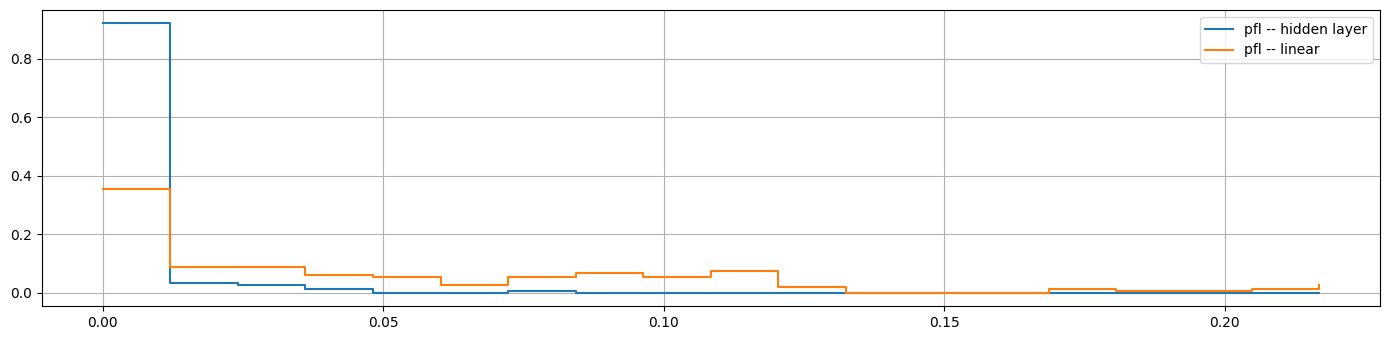

Mean: 0.003 (pfl -- hidden layer), 0.052 (pfl -- linear)


In [5]:
r_ts_acc = util.compute_regret(prb, pfl_acc, data_ts.index.values, data_ts.values)
util.plot_histogram(r_ts_acc, figsize=figsize, label='pfl -- hidden layer', data2=r_ts, label2='pfl -- linear', print_mean=True)

DFL might do better with the same model, but we the return would be diminished

## Evening the Field

**Can't we do anything about it?**

* DFL predictions will always be off (more or less)
* ...But there are ways to make the approach faster

**For example:**

* You can use a _problem relaxation_, as in [1]
* You can limit recomputation by caching past solutions, as in [2]
* You can warm start the DFL approach with the PFL weights

Let's see the last two tricks in deeper detail

<small><i>
[1] Mandi, Jayanta, and Tias Guns. "Interior point solving for lp-based prediction+ optimisation." Advances in Neural Information Processing Systems 33 (2020): 7272-7282.<br>
[2] Maxime Mulamba, Jayanta Mandi, Michelangelo Diligenti, Michele Lombardi, Victor Bucarey, Tias Guns: Contrastive Losses and Solution Caching for Predict-and-Optimize. IJCAI 2021: 2833-2840
</i></small>

## Solution Cache and Warm Start

**Solution caching is applicable if _the feasible space is fixed_**

I.e. to problems in the form:

$$
z^*(y) = \text{argmin}_{z} \{g(z) \mid \color{red}{z \in F}\}
$$

* During training, we maintain a solution cache $S$
* Initially, we populate $S$ with the true optimal solutions $z^*(y_i)$ for all examples
* Before computing $z^*(\hat{y})$ we flip a coin
* With probability $p$, we run the computation (and store any new solution in $S$)
* With probability $1 - p$, we solve instead $\hat{z}^*(y) = \text{argmin}_{z} \{g(z) \mid z \in S\}$

**Warm starting simple consists in using the PFL weights to initialize $\theta$**

Since accuracy is correlated with regret, this might accelerate convergence

## Speeding Up DFL

**Let's use DFL with linear regression, a warm start, and a solution cache**

CPU times: user 42.9 s, sys: 4.01 s, total: 46.9 s
Wall time: 46.7 s


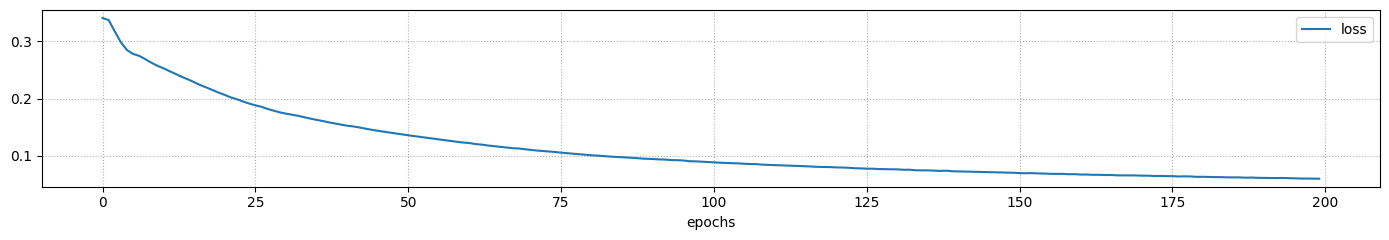

R2: 0.65, MAE: 0.12, RMSE: 0.16 (training)
R2: 0.64, MAE: 0.12, RMSE: 0.16 (test)


In [6]:
spo = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, hidden=[], name='spo', output_activation='linear', loss_type='spo', recompute_chance=0.05)
%time history = util.train_dfl_model(spo, data_tr.index.values, data_tr.values, epochs=200, verbose=0, validation_split=0, save_weights=True, load_weights=use_cached_weights, warm_start_pfl=pfl)
util.plot_training_history(history, figsize=figsize_narrow, print_final_scores=False)
util.print_ml_metrics(spo, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(spo, data_ts.index.values, data_ts.values, label='test')

The training time is still large, but much lower than our earlier DFL attempt

## Speeding Up DFL

**And the regret is even better!**

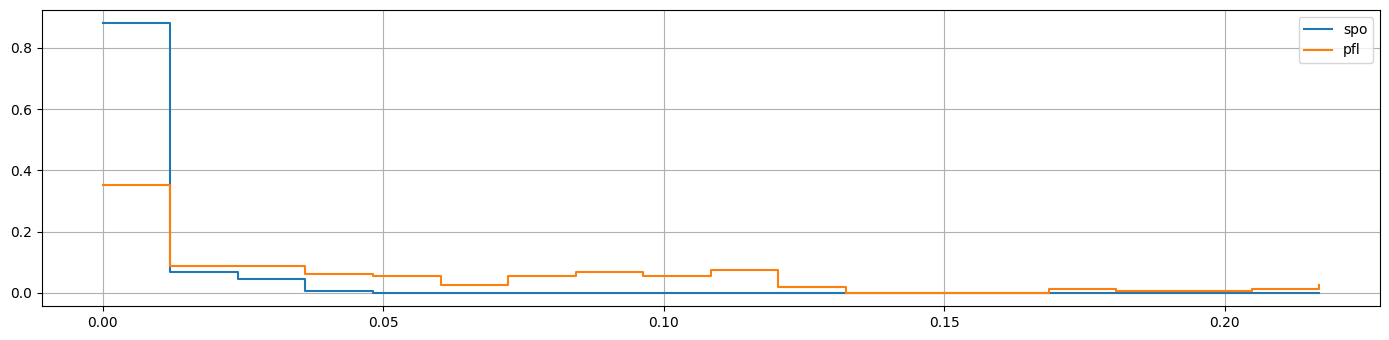

Mean: 0.004 (spo), 0.052 (pfl)


In [7]:
r_ts_spo = util.compute_regret(prb, spo, data_ts.index.values, data_ts.values)
util.plot_histogram(r_ts_spo, figsize=figsize, label='spo', data2=r_ts, label2='pfl', print_mean=True)

We are matching the more complex PFL model with a simple linear regressor

## Reflecting on What we Have

**Therefore, DFL gives us at least _two benefits_**

First, it can lead to _lower regret_ compared to a prediction-focused appraoch

* As the models become more complex we have diminishing returns
* ...But for some applications every little bit counts

Second, it may allow using _simpler ML models_

* Simple models are faster to evaluate
* ...But more importantly they are _easier to explain_
* E.g. we can easily perform feature importance analysis

> **Intuitively, DFL works best where PFL has estimation issues**<br>
> Can we exploit this fact to maximize our advantage?

## Maximizing Results

**There's a simple case where PFL _cannot make perfect predictions_**

Basically, we just need to target a _stochastic process_

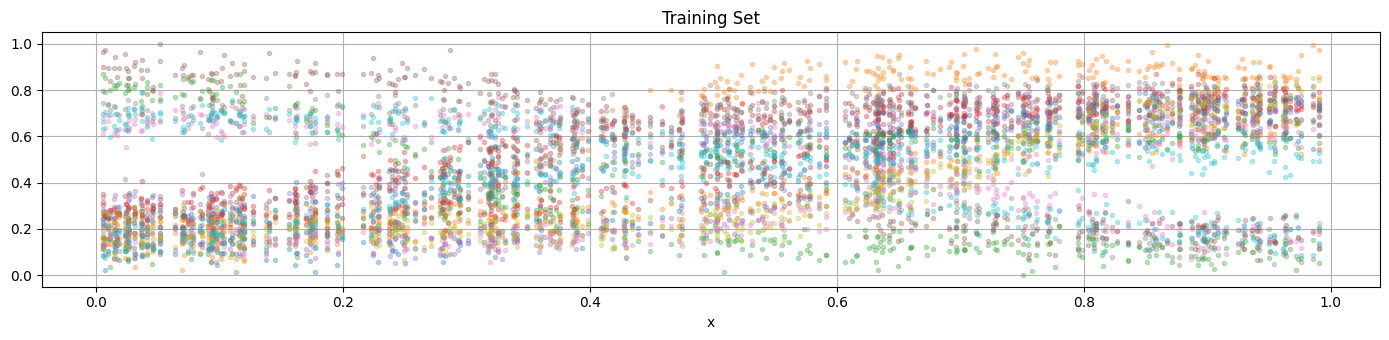

In [9]:
data_tr = util.generate_costs(nsamples=350, nitems=nitems, seed=seed, noise_scale=.15, noise_type='normal', noise_scale_type='absolute')
util.plot_df_cols(data_tr, figsize=figsize, title='Training Set', scatter=True)

Formally, we treat $X$ and $Y$ as random variables, with distribution $P(X, Y)$

## Adjusting  Goals

**But with a stochastic process, what is our real objective?**

For a given $x$, we can formalize it like this:

$$
\text{argmin}_{z} \left\{ \mathbb{E}_{y \sim P(Y \mid X=x)} [y^T z] \mid z \in F \right\}
$$

* Given a value for the observable $x$
* We want to find a single decision vector $z$
* Such that $z$ is feasible
* ...And $z$ minimized the _expected cost_ over the distribution $P(Y \mid X=x)$

> **This is called a _one-stage stochastic optimization problem_**

## ...And Keeping the Setup

**Let's look again at the DFL training problem**

$$
\theta^* = \text{argmin}_\theta \{\mathbb{E}_{(x, y) \sim P(X, Y)}[\text{regret}(\hat{y}, y)] \mid \hat{y} = h(x, \theta)\}
$$

With:

$$
\text{regret}(\hat{y}, y) = y^T z^*(\hat{y}) - y^T z^*(y)
$$

**Since $y^T z^*(y)$ is independent on $\theta$, this is equivalent to:**

$$
\theta^* = \text{argmin}_\theta \{\mathbb{E}_{(x, y) \sim P(X, Y)}[y^T z^*(\hat{y})] \mid \hat{y} = h(x, \theta)\}
$$

Which can be rewritten as:

$$
\theta^* = \text{argmin}_\theta \{\mathbb{E}_{x \sim P(X), y \sim P(Y \mid X)}[y^T z^*(\hat{y})] \mid \hat{y} = h(x, \theta)\}
$$

## ...And Keeping the Setup

**Now, let's restrict to the case where $x$ is fixed**

$$
\theta^* = \text{argmin}_\theta \{\mathbb{E}_{y \sim P(Y \mid X=x)}[y^T z^*(\hat{y})] \mid \hat{y} = h(x, \theta)\}
$$

Finally, by definition of $z^*(\cdot)$ we have:

$$
\theta^* = \text{argmin}_\theta \{\mathbb{E}_{y \sim P(Y \mid X=x)}[y^T z^*(\hat{y})] \mid \hat{y} = h(x, \theta), z^*(\hat{y}) \in F \}
$$

In other words:

* We are choosing $\theta$
* So that $z^*(\hat{y})$ minimizes $\mathbb{E}_{y \sim P(Y \mid X=x)}[y^T z^*(\hat{y})]$

> **This is _almost identical_ to one-stage stochastic optimization!**

## DFL For One-Stage Stochastic Optimization

**This means that DFL can address these problems, with one restriction and two "superpowers":**

The restriction is that _we control $z$ only through $\theta$_

* Therefore, depending on the chosen ML model architecture
* ...Obtaining some solutions might be impossible
* This issue can be sidestepped with a careful model choice

The first superpower is that we are _not restricted to a single $x$_

* Given a new value for $x$, we just need to evaluate $f(x, \theta^*)$
* ...And then solve the usual optimization problem
* Many approaches do not deal with the estimation of the $y$ distribution

**For the second superpower, we need to investigate a bit more**

## Classical Solution Approach

**What would be the classical solution approach?**

Starting from:

$$
\text{argmin}_{z} \left\{ \mathbb{E}_{y \sim P(Y \mid X=x)} [y^T z] \mid z \in F \right\}
$$

We would use linearity to obtain:

$$
\text{argmin}_{z} \left\{ \mathbb{E}_{y \sim P(Y \mid X=x)} [y]^T z \mid z \in F \right\}
$$

* So, we would first need to estimate the expected costs
* ...Then we could solve a deterministic problem

> **But isn't it what PFL is doing?**

## Regression and Expectation

**(Stochastic) Regression is often presented as learning an expectation**

...But it's trickier than that

* Using an MSE loss is equivalent to trying to learn $\mathbb{E}_{y \sim P(Y \mid X=x)} [y]$
* ...But only assuming that $P(Y \mid X=x)$ is _Normally distributed_
* ...And that it has _the same variance everywhere_

**It is possible to do the same under more general conditions**

...But it is much more complex

* If we know the distribution type, we can use a neuro-probabilistic model
* Otherwise, we need a fully fledged contextual generative model

In DFL, we can address this problem with 0 added effort!

## A Simple Stress Test

**We can test this idea by generating a stochastic dataset**

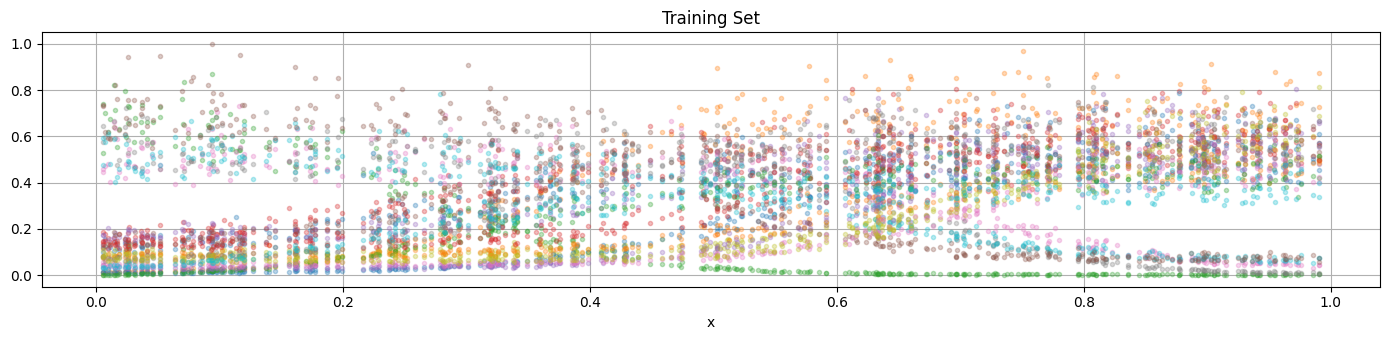

In [59]:
data_tr = util.generate_costs(nsamples=350, nitems=nitems, seed=seed, noise_scale=.2, noise_type='rayleigh', noise_scale_type='relative')
util.plot_df_cols(data_tr, figsize=figsize, title='Training Set', scatter=True)

...And scaling the variance with $y$ (a very common seeting in practice)

## A Simple Stress Test

**In our test dataset, we sample multiple $y$ values for every $x$**

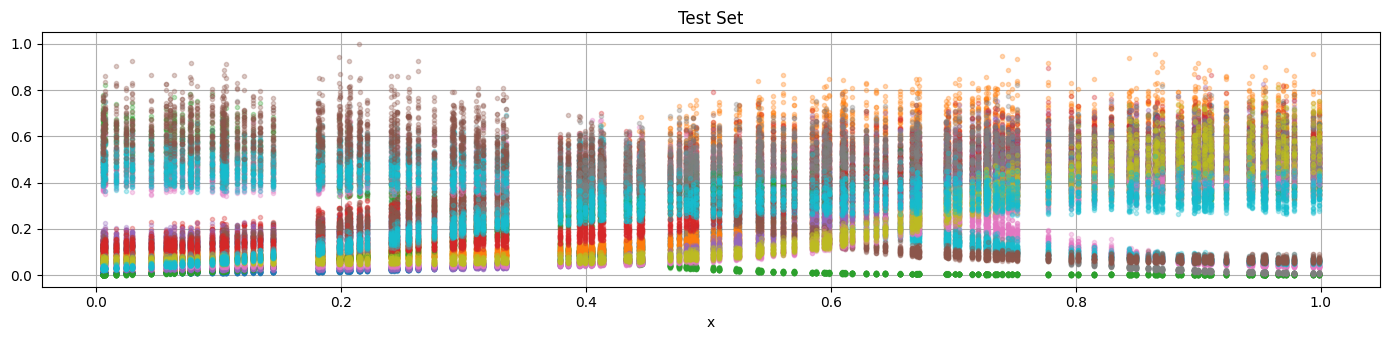

In [60]:
data_ts = util.generate_costs(nsamples=150, nitems=nitems, seed=seed, sampling_seed=seed+1, noise_scale=0.2, noise_type='rayleigh', noise_scale_type='relative', nsamples_per_point=30)
util.plot_df_cols(data_ts, figsize=figsize, title='Test Set', scatter=True)

By doing this, we get a better evaluation of the expectation

## Training a PFL Approach

**We will train a non-linear prediction focused approach**

CPU times: user 8.56 s, sys: 396 ms, total: 8.96 s
Wall time: 6.64 s


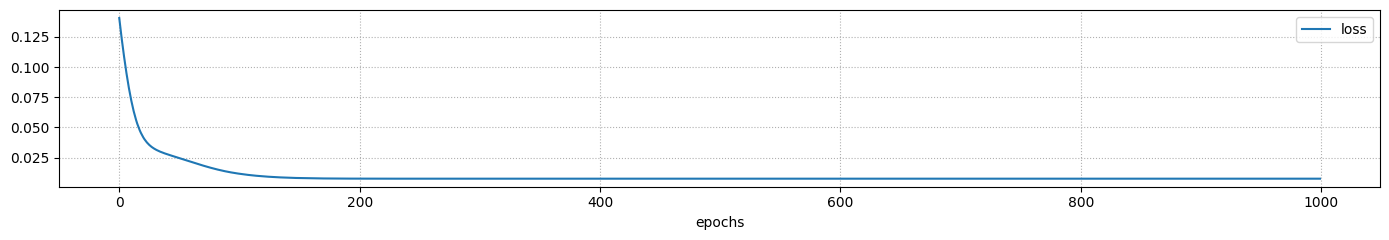

R2: 0.80, MAE: 0.07, RMSE: 0.09 (training)
R2: 0.75, MAE: 0.071, RMSE: 0.09 (test)


In [61]:
pfl_1s = util.build_nn_model(input_shape=1, output_shape=nitems, hidden=[8], name='pfl_1s', output_activation='linear')
%time history = util.train_nn_model(pfl_1s, data_tr.index.values, data_tr.values, epochs=1000, loss='mse', validation_split=0, save_weights=True, load_weights=use_cached_weights)
util.plot_training_history(history, figsize=figsize_narrow, print_final_scores=False)
util.print_ml_metrics(pfl_1s, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(pfl_1s, data_ts.index.values, data_ts.values, label='test')

The accuracy is (inevitably) worse, but still pretty good

## PFL Regret

**Let's evaluate the regret of the PFL approach**

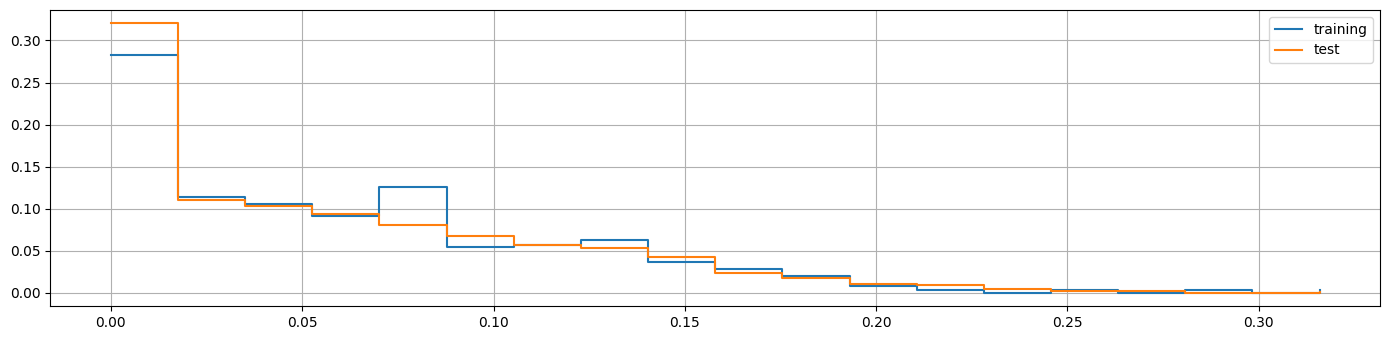

Mean: 0.063 (training), 0.061 (test)


In [62]:
r_tr_1s = util.compute_regret(prb, pfl_1s, data_tr.index.values, data_tr.values)
r_ts_1s = util.compute_regret(prb, pfl_1s, data_ts.index.values, data_ts.values)
util.plot_histogram(r_tr_1s, figsize=figsize, label='training', data2=r_ts_1s, label2='test', print_mean=True)

The regret is considerably worse, due to the effect of uncertainty

## Training a DFL Approach

**We also a DFL approach with the same non-linear model**

CPU times: user 2min 44s, sys: 10min 42s, total: 13min 26s
Wall time: 1min 23s


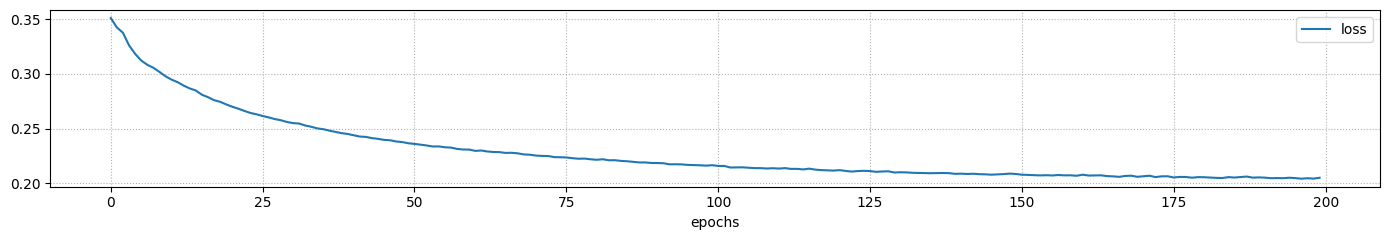

R2: 0.24, MAE: 0.13, RMSE: 0.19 (training)
R2: -0.11, MAE: 0.14, RMSE: 0.20 (test)


In [66]:
spo_1s = util.build_dfl_ml_model(input_size=1, output_size=nitems, problem=prb, hidden=[8], name='spo_1s', output_activation='linear', loss_type='spo', recompute_chance=0.05)
%time history = util.train_dfl_model(spo_1s, data_tr.index.values, data_tr.values, epochs=200, verbose=0, validation_split=0, save_weights=True, load_weights=use_cached_weights, warm_start_pfl=pfl_1s)
util.plot_training_history(history, figsize=figsize_narrow, print_final_scores=False)
util.print_ml_metrics(spo_1s, data_tr.index.values, data_tr.values, label='training')
util.print_ml_metrics(spo_1s, data_ts.index.values, data_ts.values, label='test')

## DFL Regret

**Now we can compare the regret for both approaches**

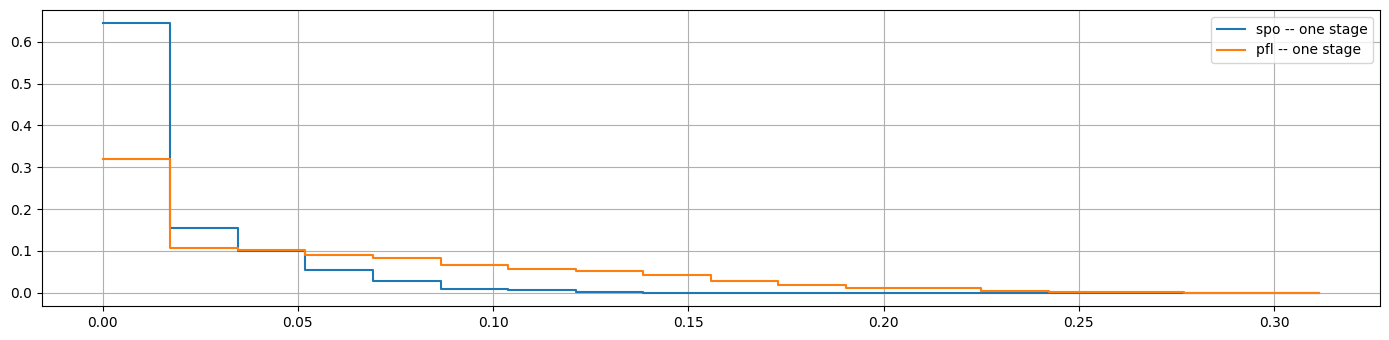

Mean: 0.017 (spo -- one stage), 0.061 (pfl -- one stage)


In [67]:
r_ts_spo_1s = util.compute_regret(prb, spo_1s, data_ts.index.values, data_ts.values)
util.plot_histogram(r_ts_spo_1s, figsize=figsize, label='spo -- one stage', data2=r_ts_1s, label2='pfl -- one stage', print_mean=True)

The gap is wider, since the PFL approach is operating on an _incorrect semantic_

## Considerations

**DFL can be thought of as a one-stage stochastic optimization approach**

In this setting:

* In particular, using a more accurate PFL model might still have poor regret
* ...Unless we know a lot about the distribution
* ...or we use a very complex estimator
* Conversely, DFL has not such issues

The gap becomes wider in case of _non-linear cost functions_:

* In this case the expected cost would not be equivalent to a sum of expectations
* But a DFL approach would have no such issues
* ...Provided it could deal with with non-linear functions